# [E-06] 인공지능 작사가 만들기

루브릭

1. 가사 텍스트 생성 모델이 정상적으로 동작하는가?
   * 텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되는가?
__ 그런거 같다..

2. 데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가?
   * 특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?
__ 그렇다

3. 텍스트 생성모델이 안정적으로 학습되었는가?
   * 텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?
__ val_loss : 1.8265 - val_accuracy: 0.7027 나왔다!

## 목록
1. 데이터 다운로드
2. 데이터 정제
3. 데이터셋 내 길이 분포
4. 데이터셋 구축하기
5. 데이터셋팅
6. 모델 구성
7. 모델 훈련 - 훈련결과 시각화
8. 모델 평가
9. 회고

# 1. 데이터 다운로드
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/song_lyrics.zip
$ unzip song_lyrics.zip -d ~/aiffel/lyricist/data/lyrics  #lyrics 폴더에 압축풀기

In [3]:
import glob
import os
import re
import numpy as np

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187090
Examples:
 ['', '', '[Spoken Intro:]']


# 2. 데이터 정제

In [4]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
#     if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

[Spoken Intro:]
You ever want something 
that you know you shouldn't have 
The more you know you shouldn't have it, 
The more you want it 
And then one day you get it, 
It's so good too 
But it's just like my girl 


In [5]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()       # 소문자로 바꾸고 양쪽 공백을 삭제
  
    # 아래 3단계를 거쳐 sentence는 스페이스 1개를 delimeter로 하는 소문자 단어 시퀀스로 바뀝니다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)        # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                  # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환

    sentence = sentence.strip()

    sentence = '<start> ' + sentence + ' <end>'      # 이전 스텝에서 본 것처럼 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다
    
    return sentence

print(preprocess_sentence("It's so good too"))   # 이 문장이 어떻게 필터링되는지 확인해 보세요.

<start> it s so good too <end>


In [6]:
corpus = [] #정제한 데이터를 corpus에 담고 다시 확인!

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if len(sentence) > 30: continue 
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> spoken intro <end>',
 '<start> you ever want something <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>',
 '<start> it s so good too <end>',
 '<start> but it s just like my girl <end>',
 '<start> when she s around me <end>',
 '<start> i just feel so good , so good <end>',
 '<start> right down to my bones <end>',
 '<start> cause ooh . . . <end>']

In [11]:
print(len("<start>  <end>"))

14


# 3. 데이터셋 내 길이 분포

In [12]:
print('문장 길이: ', len(corpus[0]))
print(' 문장 길이: ', len(corpus[1]))

문장 길이:  26
 문장 길이:  37


In [13]:
num_tokens = [len(tokens) for tokens in corpus]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  35.167973462002415
문장길이 최대 :  55
문장길이 표준편차 :  6.669175250734627


리뷰의 최대 길이 : 55
리뷰의 평균 길이 : 35.167973462002415


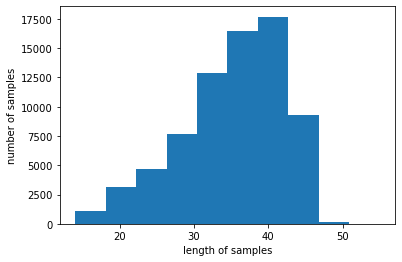

In [14]:
import matplotlib.pyplot as plt
print('리뷰의 최대 길이 :', np.max(num_tokens))
print('리뷰의 평균 길이 :', np.mean(num_tokens))
plt.hist([len(s) for s in corpus], bins=10)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
# 적절한 최대 문장길이 지정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_len = 15
print('pad_sequences maxlen : ', max_len)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  15
전체 문장의 0.9996298936286874%가 maxlen 설정값 이내에 포함됩니다. 


In [16]:
# 토큰화
import tensorflow as tf

def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,  # 전체 단어의 개수 
        filters=' ',   
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   #corpus로부터 Tokenizer가 단어사전 자동생성.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # 사전에서 corpus를 해석해 Tensor로 변환합니다.

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=max_len)  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2 1762 1408 ...    0    0    0]
 [   2    6  181 ...    0    0    0]
 [   2    7  108 ...    0    0    0]
 ...
 [   2   30   31 ...    0    0    0]
 [   2    4   43 ...    0    0    0]
 [   2   19   16 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fac5da4e6d0>


In [17]:
print(tensor[:3, :10])

[[   2 1762 1408    3    0    0    0    0    0    0]
 [   2    6  181   61  245    3    0    0    0    0]
 [   2    7  108    6   61   11    3    0    0    0]]


In [18]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : you
7 : the
8 : and
9 : a
10 : to


# 4. 데이터 셋 구축하기

In [19]:
src_input = tensor[:, :-1]  # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다. 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
tgt_input = tensor[:, 1:]    # tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.

print(src_input[0])
print(tgt_input[0])

[   2 1762 1408    3    0    0    0    0    0    0    0    0    0    0]
[1762 1408    3    0    0    0    0    0    0    0    0    0    0    0]


In [20]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,tgt_input,test_size=0.2,shuffle=True) 
print("Source Train:", enc_train.shape)
print("Target Train:", enc_val.shape)
print("Source Test:", dec_train.shape)
print("Target Test:", dec_val.shape)

Source Train: (58361, 14)
Target Train: (14591, 14)
Source Test: (58361, 14)
Target Test: (14591, 14)


In [21]:
# Hyper-parameters setting
buffer_size = len(src_input)
batch_size = 256
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/lyricist/models/check'

checkpoint_dir

'/home/aiffel-dj54/aiffel/lyricist/models/check'

# 5. DATA SETTING

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(buffer_size)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(buffer_size)
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)
train_dataset, test_dataset

(<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>,
 <BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>)

# 6. 모델 구성

In [23]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256 #차원을 결정 , vocab size와 같음
hidden_size = 1024 #몇명의 일꾼을 둘것인지 결정
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [24]:
#총 12001개의 정보를 1batch에 256개를 넣어서 계산

for src_sample, tgt_sample in train_dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[ 8.7232283e-06, -1.2839813e-04,  8.4584208e-05, ...,
          1.4149012e-04, -1.6323544e-04, -1.4181418e-04],
        [-2.1486057e-04, -2.3602067e-04,  6.8523645e-05, ...,
          3.5888347e-04, -2.3425973e-04, -1.2104704e-04],
        [-1.8673635e-04, -5.7022291e-04, -3.4830315e-05, ...,
          3.4845163e-04, -3.3159921e-04, -2.3493401e-04],
        ...,
        [-2.4230129e-03,  1.4113135e-03, -1.2717377e-03, ...,
         -6.0748495e-04, -3.3056608e-03,  1.0182577e-03],
        [-2.6658690e-03,  1.6097085e-03, -1.5722472e-03, ...,
         -6.0291507e-04, -3.6445900e-03,  1.2006443e-03],
        [-2.8842932e-03,  1.7718320e-03, -1.8443369e-03, ...,
         -5.7277386e-04, -3.9421031e-03,  1.3659653e-03]],

       [[ 8.7232283e-06, -1.2839813e-04,  8.4584208e-05, ...,
          1.4149012e-04, -1.6323544e-04, -1.4181418e-04],
        [-1.1350843e-04, -3.1707069e-04,  4.3900032e-05, ...,
          2.2120957e-04, 

In [25]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [26]:
optimizer=tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss,
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [27]:
#val loss를 모니터하고 loss가 낮아지면 자동을 모델파라미터 저장
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


# 7. 모델 훈련
  call back 함수
- 모델 fit 함수 쓸때, call back 함수로 중간에 원하는 동작하도록 설정
- 모델 재사용하기 위해 모델 가중치 저장

In [28]:
history= model.fit(train_dataset, epochs=max_epochs,
        steps_per_epoch=len(enc_train) // batch_size,
        validation_data=test_dataset,
        validation_steps=len(enc_val) // batch_size,
        callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
227/227 [==============================] - ETA: 0s - loss: 2.7298 - accuracy: 0.6243
Epoch 00001: val_loss improved from inf to 2.30776, saving model to /home/aiffel-dj54/aiffel/lyricist/models/check
227/227 [==============================] - 33s 147ms/step - loss: 2.7298 - accuracy: 0.6243 - val_loss: 2.3078 - val_accuracy: 0.6583
Epoch 2/10
227/227 [==============================] - ETA: 0s - loss: 2.2231 - accuracy: 0.6607
Epoch 00002: val_loss improved from 2.30776 to 2.18391, saving model to /home/aiffel-dj54/aiffel/lyricist/models/check
227/227 [==============================] - 34s 148ms/step - loss: 2.2231 - accuracy: 0.6607 - val_loss: 2.1839 - val_accuracy: 0.6650
Epoch 3/10
227/227 [==============================] - ETA: 0s - loss: 2.0919 - accuracy: 0.6699
Epoch 00003: val_loss improved from 2.18391 to 2.08324, saving model to /home/aiffel-dj54/aiffel/lyricist/models/check
227/227 [==============================] - 34s 149ms/step - loss: 2.0919 - accuracy: 0.6699

# 8. 훈련 결과

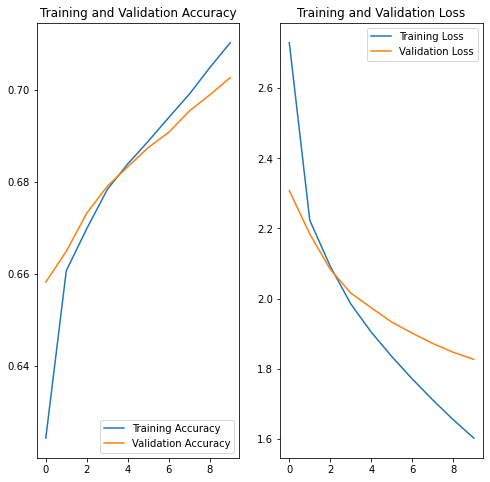

✅


In [30]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [34]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=30):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)   
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

In [36]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=30)

'<start> i love you <end> '

# 9. 회고

## 프로젝트하면서 생긴 문제점
1. 토큰길이 줄이기
* 토큰의 길이를 15로 줄이는 과정이 너무 헷갈렸다.
* 토큰의 길이를 줄여야하는데 문장길이를 줄이는 방법만 알고 있어서 어떤 함수를 사용해야할지 몰랐었다. 
* 프로젝트 4를 참고해서 토큰 길이 지정하는 방법을 알았지만 토큰전에 하는지 후에 하는지 몰라서 헤멨다. (토큰화 공부 더 필요함을 느꼈다)

해결: 프로젝트 4를 참고해서 문장길이 확인- 적절한 문장길이 지정(여기서 max_len을 지정한다)- 토큰화 

2. 데이터셋 구축하기
* 프로젝트 6에서 데이터를 나누는 부분이 명확하게 이해가 안됐다. 여태 numpy array 형식으로 진행해서 프로젝트6를 참고하지 않고 프로젝트4를 보고 데이터를 나눴다. 데이터 셋을 안만들고 모델에 적용하려고 했지만 text generator를 사용할때 데이터 셋을 만들어야해서 
* tf.data.Dataset에서 data.dataset.from_tensor_slice()메소드 사용해서 dataset 생성

3. git hub에 push 하는 과정에서 프로젝트가 날라갔다...
* 결국 기한을 넘기고 밤에 다시 만들었다...
* 같은 코드를 사용했지만 오류를 엄청나게 많이 만났다.

4. 오류1) 첫번째 코드에서 유니코드 오류(utf-8' codec can't decode byte 0xdf in position 1: invalid continuation byte)가 떴다.  

* with open(txt_file, "r")- 여기서 r -->rb 로 바꾸거나 encoding으로 조절을 해줘야한다.

* 오류2) 데이터 불러올때 데이터 크기가 9만개가 나왔다...
* 문제: check point 자료를 파일에 넣어서 파일의 양이 엄청 많았었다. 
* 파일 경로 설정이 중요함을 다시 느꼈다. 

5. 데이터 정제에서  if len(sentence) > 30: continue  sentence 길이를 제한했다. 
하지만 문장길이가 55다... 
start와 end 길이는 15정도인데 왜 55가 나왔는지 의문이었다. 

고민 끝에 알게 된점은 max_len이 전처리를 거치면서 토큰단위로 공백을 추가해서 문장 길이가 증가했다. 
